In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd

from mcstools.loader import L2Loader
from mcstools.mcsfile import L2File

"""
Search DDR1 records over some time range and
find profiles within various bounds.
"""



'\nSearch DDR1 records over some time range and\nfind profiles within various bounds.\n'

In [2]:
config = {
    "dt": ("2007-01-01", "2007-01-02"),
    "Profile_lat": (-20, 20),
    #"Gqual": [0, 5, 6],
    "Obs_qual": [0, 1, 10]
}

bin_config = {
    "L_s": (0, 360, 5),
    "Profile_lat": (-90, 90, 5),
    "Profile_lon": (-180, 180, 5),
    "LTST": (0, 1, 6)
}

data_dir=None

In [3]:
def parse_config(ddr1_df, config_dict):
    for field, vals in config_dict.items():
        if field in ["dt", "Ls"]:
            continue
        else:
            if type(vals) in [tuple]:
                print(f"Filtering {field} to within {vals}.")
                ddr1_df = ddr1_df[ddr1_df[field].between(*vals)]
            if type(vals) in [list]:
                print(f"Selecting rows with {field} in {vals}.")
                ddr1_df = ddr1_df[ddr1_df[field].isin(vals)]
    return ddr1_df

def bin_ddr1_profiles(ddr1_df, bin_config):
    # goal is an xarray with coords MY, L_s_mid, lat_mid, lon_mid, ltst_mid(?)
    # and values are the profile identifiers
    for bin_col, bin_params in bin_config.items():
        print(f"Binning {bin_col}")
        bins = np.arange(bin_params[0], bin_params[1]+bin_params[2], bin_params[2])
        mid_points = (bins[1:]+bins[:-1])/2
        ddr1_df[f"{bin_col}_mid"] = pd.cut(ddr1_df[bin_col], bins=bins, labels=mid_points)
    return ddr1_df

In [4]:
if data_dir:
    l2loader = L2Loader(mcs_data_path = data_dir)
else:
    l2loader = L2Loader(pds=True)
if "dt" in config.keys() and "Ls" not in config.keys():
    ddr1 = l2loader.load_date_range(*config["dt"], ddr="DDR1", add_cols=["dt"])
    print(ddr1)
reduced_ddr1 = parse_config(ddr1, config)
print(reduced_ddr1)
binned = bin_ddr1_profiles(reduced_ddr1, bin_config)
#print(binned[list(bin_config.keys())+[f"{x}_mid" for x in bin_config.keys()]])
#binned_grouped = binned.groupby(list(bin_config.keys()), as_index=True)[["Profile_identifier"]]
#print(binned_grouped)
#binned_xr = binned.set_index(list(bin_config.keys()))["Profile_identifier"].to_xarray()
#print(binned_xr)

Loading L2 DDR1 data from 2007-01-01 00:00:00 - 2007-01-02 00:00:00
['https://atmos.nmsu.edu/PDS/data//MROM_2005/DATA/2007/200701/20070101/2007010100_DDR.TAB', 'https://atmos.nmsu.edu/PDS/data//MROM_2005/DATA/2007/200701/20070101/2007010104_DDR.TAB', 'https://atmos.nmsu.edu/PDS/data//MROM_2005/DATA/2007/200701/20070101/2007010108_DDR.TAB', 'https://atmos.nmsu.edu/PDS/data//MROM_2005/DATA/2007/200701/20070101/2007010112_DDR.TAB', 'https://atmos.nmsu.edu/PDS/data//MROM_2005/DATA/2007/200701/20070101/2007010116_DDR.TAB', 'https://atmos.nmsu.edu/PDS/data//MROM_2005/DATA/2007/200701/20070101/2007010120_DDR.TAB', 'https://atmos.nmsu.edu/PDS/data//MROM_2005/DATA/2007/200701/20070102/2007010200_DDR.TAB'] None
      1         Date           UTC           SCLK        L_s    Solar_dist  \
0     0  01-Jan-2007  00:00:19.745  852076838.616  159.38547  2.265703e+08   
1     0  01-Jan-2007  00:00:50.464  852076869.336  159.38566  2.265703e+08   
2     0  01-Jan-2007  00:01:21.184  852076900.056  159.

In [5]:
x = binned.groupby([f"{x}_mid" for x in bin_config.keys()], as_index=True)["Profile_identifier"].agg(list)

In [9]:
x.dropna().iloc[0]

['070101200000_156', '070101200000_157', '070101200000_158']

In [30]:
x.loc[157.5, 12.5, -2.5, 3]

['070101080000_219',
 '070101080000_220',
 '070101200000_255',
 '070101200000_256',
 '070101200000_257']

In [16]:
x_xr = x.to_xarray()
x_xr.coords

Coordinates:
  * L_s_mid          (L_s_mid) float64 2.5 7.5 12.5 17.5 ... 347.5 352.5 357.5
  * Profile_lat_mid  (Profile_lat_mid) float64 -87.5 -82.5 -77.5 ... 82.5 87.5
  * Profile_lon_mid  (Profile_lon_mid) float64 -177.5 -172.5 ... 172.5 177.5
  * LTST_mid         (LTST_mid) float64 3.0

In [18]:
x_xr.sel(L_s_mid=157.5, Profile_lat_mid=12.5, Profile_lon_mid=-2.5, LTST_mid=3.0)

<xarray.DataArray 'Profile_identifier' ()>
array(list(['070101080000_219', '070101080000_220', '070101200000_255', '070101200000_256', '070101200000_257']),
      dtype=object)
Coordinates:
    L_s_mid          float64 157.5
    Profile_lat_mid  float64 12.5
    Profile_lon_mid  float64 -2.5
    LTST_mid         float64 3.0

In [19]:
profiles = x_xr.sel(L_s_mid=157.5, Profile_lat_mid=12.5, Profile_lon_mid=-2.5).item()

In [22]:
ddr2 = L2Loader(pds=True).load("DDR2", profiles=profiles)

In [68]:
ddr2

,1,Pres,T,T_err,Dust,Dust_err,H2Ovap,H2Ovap_err,H2Oice,H2Oice_err,CO2ice,CO2ice_err,Alt,Lat,Lon,Profile_identifier,level
0,0,1878.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,070101080000_219,0
1,0,1658.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,070101080000_219,1
2,0,1463.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,070101080000_219,2
3,0,1291.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,070101080000_219,3
4,0,1139.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,070101080000_219,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,0,0.007002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.639,12.047,-4.176,070101200000_257,100
521,0,0.006179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.720,11.990,-4.169,070101200000_257,101
522,0,0.005453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.801,11.934,-4.162,070101200000_257,102
523,0,0.004812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.883,11.877,-4.155,070101200000_257,103


In [63]:
ex_profile = ddr2.groupby("Profile_identifier").get_group("070101080000_219")

In [80]:
import xarray as xr
ex_xr = xr.Dataset(
    data_vars={"T": (["level"], ex_profile["T"])},
    coords={
        "level": ("level", ex_profile["level"]),
        "Pres": ("level", ex_profile["Pres"]),
        "Alt": ("level", ex_profile["Alt"]),
    }
)["T"]
print(ex_xr)

<xarray.DataArray 'T' (level: 105)>
array([    nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan, 220.392, 219.762, 218.541, 216.694, 214.315,
       211.436, 208.329, 205.202, 202.288, 199.695, 197.481, 195.695,
       194.251, 193.09 , 192.157, 191.308, 190.362, 189.271, 188.039,
       186.634, 185.018, 183.198, 181.338, 179.777, 178.812, 178.469,
       178.521, 178.691, 178.821, 178.845, 178.653, 178.092, 177.102,
       175.693, 173.883, 171.629, 168.847, 165.598, 162.225, 159.049,
       156.199, 153.679, 151.407, 149.337, 147.477, 145.841, 144.408,
       143.115, 141.91 , 140.783, 139.777, 139.004, 138.605, 138.6  ,
       138.97 , 139.57 , 140.163, 140.561, 140.683, 140.599, 140.535,
       140.747, 141.401, 142.521, 143.856, 144.885, 145.178, 144.583,
       143.37 , 142.198, 141.644, 141.957, 143.   , 144.163, 144.821,
       144.648, 143.722, 142.504, 141.429, 140.708, 140.338, 140.152,
       140.023, 139.91 , 139.805,     nan,     nan,   

In [88]:
ddr2_xr = ddr2.set_index(
    ["Profile_identifier", "level"]
)[["Pres", "Alt", "T", "T_err", "Dust", "Dust_err", "H2Oice", "H2Oice_err", "Lat", "Lon"]].to_xarray()

#ddr2_xr.assign_coords({"L_s_mid": 157.5}, )
ddr2_xr = ddr2_xr.assign_coords({"Pres":ddr2_xr["Pres"], "Alt":ddr2_xr["Alt"]})
ddr2_xr

<xarray.Dataset>
Dimensions:             (Profile_identifier: 5, level: 105)
Coordinates:
  * Profile_identifier  (Profile_identifier) object '070101080000_219' ... '0...
  * level               (level) int64 0 1 2 3 4 5 6 ... 99 100 101 102 103 104
    Pres                (Profile_identifier, level) float64 1.879e+03 ... 0.0...
    Alt                 (Profile_identifier, level) float64 nan nan ... 105.0
Data variables:
    T                   (Profile_identifier, level) float64 nan nan ... nan nan
    T_err               (Profile_identifier, level) float64 nan nan ... nan nan
    Dust                (Profile_identifier, level) float64 nan nan ... nan nan
    Dust_err            (Profile_identifier, level) float64 nan nan ... nan nan
    H2Oice              (Profile_identifier, level) float64 nan nan ... nan nan
    H2Oice_err          (Profile_identifier, level) float64 nan nan ... nan nan
    Lat                 (Profile_identifier, level) float64 nan nan ... 11.82
    Lon                 (Profile_identifier, level) float64 nan nan ... -4.149

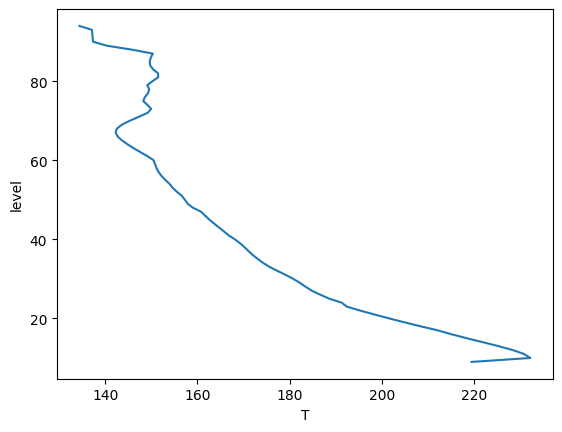

In [94]:
ddr2_xr.median("Profile_identifier")["T"].plot(y="level")

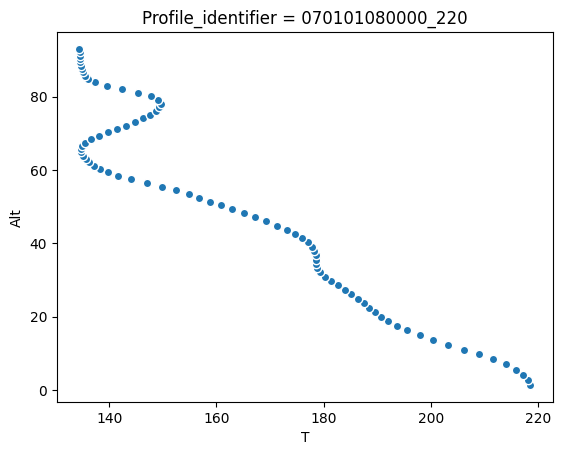

In [47]:
ddr2.set_index(
    ["Profile_identifier", "level"]
)[["Pres", "T", "Alt"]].to_xarray().isel(Profile_identifier=1).plot.scatter(x="T", y="Alt")